In [ ]:
# Author: Krutarth Parmar
# Date: 2025-04-03
'''
This is presented as solution for GSOC 2025 ML4SCI Task 2J for Discovery of hidden symmetries and conservation laws
Dataset Preparation: Use the vanilla MNIST dataset for this purpose. Rotate every sample in steps of 30 degrees and store them in a data format of your choice. Only use the digits 1 and 2 from the dataset if the computational budget is limited.Latent Space Creation: Build an Variational Auto-Encoder of your choice and train it using the dataset prepared in the previous step
'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data = np.load('mnist_rotated_1_2.npz')

In [3]:
x_numpy = data['x']
min_val = x_numpy.min()
max_val = x_numpy.max()

#scale to [0,1]
x_normalized = (x_numpy - min_val) / (max_val - min_val)

In [4]:
x_tensor = torch.tensor(x_normalized, dtype=torch.float32)

# Permute dimensions from (N, H, W, C) to (N, C, H, W)
#    N=122784, H=28, W=28, C=1
x_tensor = x_tensor.permute(0, 3, 1, 2)
print(f"Tensor shape: {x_tensor.shape}")

Tensor shape: torch.Size([122784, 1, 28, 28])


# VAE Model


In [5]:
latent_dim = 16
intermediate_dim = 128

class VAE(nn.Module):
    def __init__(self, latent_dim=16, intermediate_dim=128):
        super(VAE, self).__init__()

        # --- Encoder ---
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # -> (N, 32, 14, 14)
        self.bn1 = nn.BatchNorm2d(32) # Added BatchNorm
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # -> (N, 64, 7, 7)
        self.bn2 = nn.BatchNorm2d(64) # Added BatchNorm
        # Flattened size: 64 * 7 * 7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, intermediate_dim)
        self.bn3 = nn.BatchNorm1d(intermediate_dim) # Added BatchNorm

        self.fc_mu = nn.Linear(intermediate_dim, latent_dim)
        self.fc_logvar = nn.Linear(intermediate_dim, latent_dim)

        # --- Decoder ---
        self.fc_decode1 = nn.Linear(latent_dim, intermediate_dim)
        self.bn4 = nn.BatchNorm1d(intermediate_dim) # Added BatchNorm
        self.fc_decode2 = nn.Linear(intermediate_dim, 64 * 7 * 7)
        self.bn5 = nn.BatchNorm1d(64 * 7 * 7) # Added BatchNorm

        self.conv_t1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # -> (N, 32, 14, 14)
        self.bn6 = nn.BatchNorm2d(32) # Added BatchNorm
        self.conv_t2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1) # -> (N, 1, 28, 28)
        # NO BatchNorm before final Sigmoid

    def encode(self, x):
        # Apply Conv -> BatchNorm -> ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.bn3(self.fc1(x)))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x) # No activation/BN on mu/logvar outputs
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Apply Linear -> BatchNorm -> ReLU
        z = F.relu(self.bn4(self.fc_decode1(z)))
        z = F.relu(self.bn5(self.fc_decode2(z)))
        z = z.view(z.size(0), 64, 7, 7) # Reshape
        # Apply ConvTranspose -> BatchNorm -> ReLU
        z = F.relu(self.bn6(self.conv_t1(z)))
        # Final layer -> Sigmoid (NO BatchNorm here)
        reconstruction = torch.sigmoid(self.conv_t2(z))
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


batch_size = 128
dataset = TensorDataset(x_tensor)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
print(model)

VAE(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=16, bias=True)
  (fc_decode1): Linear(in_features=16, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_decode2): Linear(in_features=128, out_features=3136, bias=True)
  (bn5): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t1): ConvTranspose2d(64, 32, kernel_size=(4, 4), strid

In [6]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Define the loss function
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction Loss (Binary Cross-Entropy)
    # Flatten images and compare pixel-wise
    # Using reduction='sum' sums the loss over all elements and batch
    BCE = F.binary_cross_entropy(recon_x.view(-1, 1*28*28), x.view(-1, 1*28*28), reduction='sum')

    # KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # Note: logvar = log(sigma^2) -> sigma^2 = exp(logvar)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Loss
    # We want to maximize ELBO (Evidence Lower Bound), which is equivalent to minimizing (-ELBO)
    # -ELBO = - (log p(x|z) - KL[q(z|x)||p(z)])
    # Assuming log p(x|z) is represented by -BCE (common approximation)
    # Loss = BCE - KLD --> Minimize this value
    return BCE - beta * KLD # Note the minus sign for KLD

# Choose an Optimizer
learning_rate = 5e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Loss function defined.")
print("Optimizer (Adam) initialized.")

Loss function defined.
Optimizer (Adam) initialized.


In [7]:
# Before starting the training loop:
print(f"Checking input tensor for NaNs: {torch.isnan(x_tensor).any()}")
print(f"Checking input tensor for Infs: {torch.isinf(x_tensor).any()}")

Checking input tensor for NaNs: False
Checking input tensor for Infs: False


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Training Parameters ---
epochs = 20 # Number of epochs to train for (adjust as needed)
print_every = 1 # Print loss every 'print_every' epochs

print(f"\nStarting training for {epochs} epochs...")

# --- Training Loop ---
model.train() # Set model to training mode

for epoch in range(1, epochs + 1):
    warmup_epochs = 30
    target_beta = 0.1 
    epoch_loss = 0.0
    epoch_bce_loss = 0.0
    epoch_kld_loss = 0.0

    beta = min(target_beta, (epoch / warmup_epochs) * target_beta)

    for batch_idx, data in enumerate(dataloader):
        # Data comes as a list/tuple from DataLoader, get the tensor
        batch_data = data[0]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Get reconstruction, mu, and logvar
        recon_batch, mu, logvar = model(batch_data)

        if batch_idx == 0 and epoch % print_every == 0: # Check once per print cycle
             print(f"\nEpoch {epoch}, Batch 0 Stats:")
             print(f"  Mu min/max/mean: {mu.min().item():.4f} / {mu.max().item():.4f} / {mu.mean().item():.4f}")
             print(f"  LogVar min/max/mean: {logvar.min().item():.4f} / {logvar.max().item():.4f} / {logvar.mean().item():.4f}")
             # Check for NaNs/Infs
             if torch.isnan(mu).any() or torch.isinf(mu).any(): print("  WARNING: NaNs/Infs in Mu!")
             if torch.isnan(logvar).any() or torch.isinf(logvar).any(): print("  WARNING: NaNs/Infs in LogVar!")

        # Calculate loss
        # Use the full batch_data for comparison
        loss = vae_loss_function(recon_batch, batch_data, mu, logvar, beta=beta) # Pass beta

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients
        optimizer.step()

        # --- Accumulate losses for logging ---
        # Calculate individual components again just for reporting
        # Note: It's slightly redundant but ensures we log consistent values
        # related to the loss that was just backpropagated.
        with torch.no_grad(): # Don't track gradients for logging calculations
             bce_component = F.binary_cross_entropy(recon_batch.view(-1, 1*28*28),
                                                  batch_data.view(-1, 1*28*28),
                                                  reduction='sum')
             kld_component = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        epoch_loss += loss.item()
        epoch_bce_loss += bce_component.item()
        epoch_kld_loss += kld_component.item() # Remember KLD in loss func is -KLD term

    # Calculate average losses per sample for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader.dataset)
    avg_bce_loss = epoch_bce_loss / len(dataloader.dataset)
    avg_kld_loss = -epoch_kld_loss / len(dataloader.dataset) # Correct sign for reporting

    if epoch % print_every == 0:
        print(f'Epoch [{epoch}/{epochs}] - Avg Loss: {avg_epoch_loss:.4f} | '
              f'Avg BCE: {avg_bce_loss:.4f} | Avg KLD: {avg_kld_loss:.4f}')

print("Training finished.")

# --- Save the trained model ---
model_save_path = 'vae_rotated_mnist_1_2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model state dictionary saved to {model_save_path}")


# --- Evaluation & Visualization ---
print("\nVisualizing results...")
model.eval() # Set model to evaluation mode

def visualize_reconstruction(model, data_loader, device, n_samples=10):
    """Shows original and reconstructed images."""
    model.eval()
    with torch.no_grad():
        # Get a batch of original images
        dataiter = iter(data_loader)
        images = next(dataiter)[0].to(device) # Get first element of tuple

        # Get reconstructions
        recon_images, _, _ = model(images)

        # Move images back to CPU for plotting
        images = images.cpu()
        recon_images = recon_images.cpu()

        plt.figure(figsize=(20, 4))
        for i in range(n_samples):
            # Display original
            ax = plt.subplot(2, n_samples, i + 1)
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0: ax.set_title("Original Images")

            # Display reconstruction
            ax = plt.subplot(2, n_samples, i + 1 + n_samples)
            plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0: ax.set_title("Reconstructed Images")
        plt.suptitle('VAE Reconstructions', fontsize=16)
        plt.show()

def visualize_generation(model, device, latent_dim, n_samples=10):
    """Generates images from random latent vectors."""
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from the prior N(0, I)
        random_z = torch.randn(n_samples, latent_dim).to(device)

        # Decode the random vectors
        generated_images = model.decode(random_z)

        # Move images to CPU for plotting
        generated_images = generated_images.cpu()

        plt.figure(figsize=(15, 3))
        for i in range(n_samples):
            ax = plt.subplot(1, n_samples, i + 1)
            plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.suptitle('VAE Generated Samples', fontsize=16)
        plt.show()

# Run visualizations
visualize_reconstruction(model, dataloader, None, n_samples=10)
visualize_generation(model, None, latent_dim, n_samples=10)


Starting training for 20 epochs...

Epoch 1, Batch 0 Stats:
  Mu min/max/mean: -1.3281 / 1.3176 / 0.0176
  LogVar min/max/mean: -1.2520 / 1.4671 / 0.0234
Epoch [1/20] - Avg Loss: 417.6594 | Avg BCE: 417.7401 | Avg KLD: -24.1997

Epoch 2, Batch 0 Stats:
  Mu min/max/mean: -5.1909 / 5.2119 / -0.0072
  LogVar min/max/mean: -5.6987 / -1.2896 / -3.2864
Epoch [2/20] - Avg Loss: 388.0936 | Avg BCE: 388.4179 | Avg KLD: -48.6457

Epoch 3, Batch 0 Stats:
  Mu min/max/mean: -5.1661 / 5.4399 / -0.0199
  LogVar min/max/mean: -7.6918 / -2.4119 / -4.9396
Epoch [3/20] - Avg Loss: 385.5932 | Avg BCE: 386.2499 | Avg KLD: -65.6772

Epoch 4, Batch 0 Stats:
  Mu min/max/mean: -5.7882 / 6.3728 / -0.0359
  LogVar min/max/mean: -11.1690 / -3.9219 / -6.4272
Epoch [4/20] - Avg Loss: 383.9669 | Avg BCE: 385.1693 | Avg KLD: -90.1813

Epoch 5, Batch 0 Stats:
  Mu min/max/mean: -6.9843 / 7.7643 / -0.0588
  LogVar min/max/mean: -14.4461 / -5.4958 / -8.4332
Epoch [5/20] - Avg Loss: 382.2270 | Avg BCE: 384.5706 | Avg

KeyboardInterrupt: 

In [9]:
model_save_path = 'vae_rotated_mnist_1_2_epoch8.pth' # Or similar name
torch.save(model.state_dict(), model_save_path)
print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to vae_rotated_mnist_1_2_epoch8.pth



Generating reconstruction visualization...


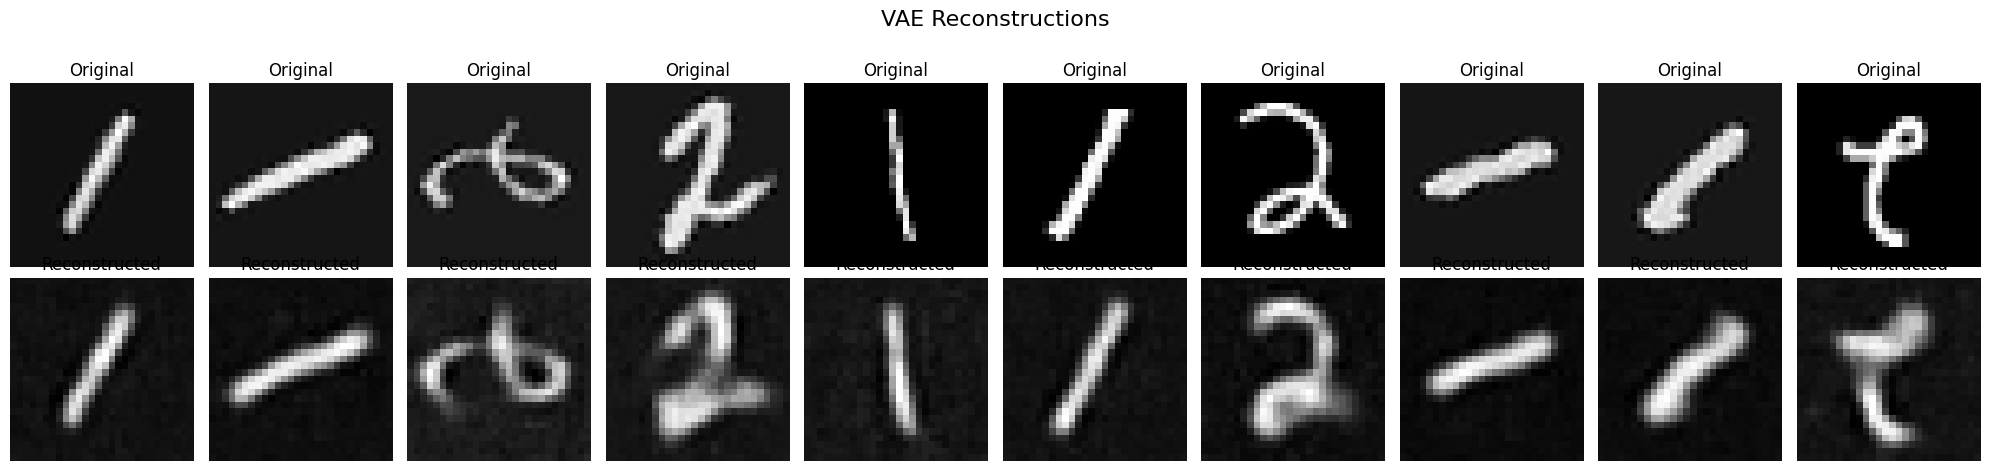


Generating new samples visualization...


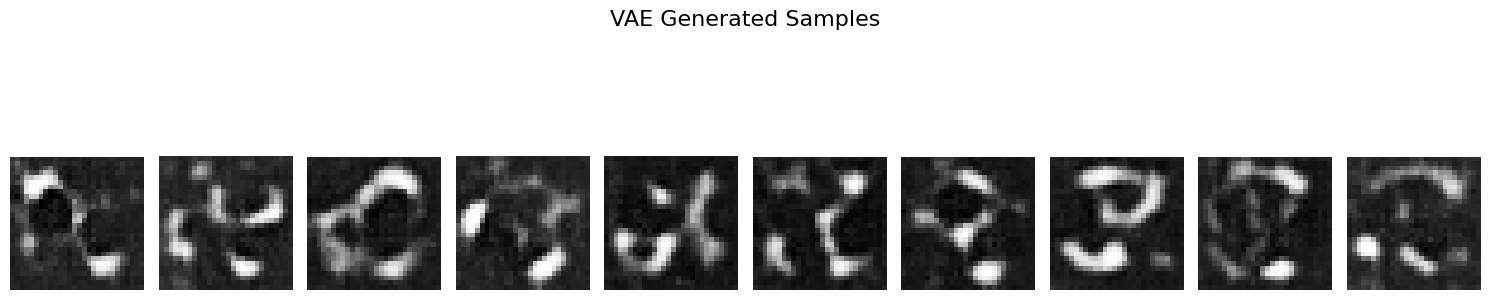

In [13]:
# --- Visualization Functions ---

NUM_SAMPLES_TO_SHOW = 10

def visualize_reconstruction(model, data_loader, device, n_samples=10):
    """Shows original and reconstructed images."""
    model.eval() # Ensure model is in eval mode

    # Get a batch of original images from the dataloader
    try:
        original_images = next(iter(data_loader))[0] # Get the first element (images)
    except StopIteration:
        print("DataLoader is empty or exhausted.")
        return
    except Exception as e:
        print(f"Error getting data from DataLoader: {e}")
        return
    

    # Ensure we don't take more samples than the batch size
    n_samples = min(n_samples, original_images.size(0))
    original_images = original_images[:n_samples] # Select samples

    # Move images to the correct device
    original_images = original_images.to(device)

    # Perform reconstruction
    with torch.no_grad(): # Disable gradient calculations for inference
        recon_images, mu, logvar = model(original_images)

    # Move images back to CPU for plotting with Matplotlib
    original_images = original_images.cpu()
    recon_images = recon_images.cpu()

    # Plotting
    plt.figure(figsize=(20, 5)) # Adjust figure size as needed
    plt.suptitle('VAE Reconstructions', fontsize=16)

    for i in range(n_samples):
        # Display original image
        ax = plt.subplot(2, n_samples, i + 1) # 2 rows, n_samples columns, index i+1
        # Reshape from (1, 28, 28) or similar to (28, 28) for imshow
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        ax.axis('off') # Hide axes ticks

        # Display reconstructed image
        ax = plt.subplot(2, n_samples, i + 1 + n_samples) # Index i+1 + n_samples for second row
        plt.imshow(recon_images[i].squeeze(), cmap='gray')
        ax.set_title("Reconstructed")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

def visualize_generation(model, device, latent_dim, n_samples=10):
    """Generates images from random latent vectors."""
    model.eval() # Ensure model is in eval mode

    # Sample random latent vectors from the prior distribution N(0, I)
    # Shape: (number of samples, latent dimension)
    random_z = torch.randn(n_samples, latent_dim).to(device)

    # Generate images by passing random z through the decoder ONLY
    with torch.no_grad(): # Disable gradient calculations
        generated_images = model.decode(random_z)

    # Move generated images to CPU for plotting
    generated_images = generated_images.cpu()

    # Plotting
    plt.figure(figsize=(15, 4)) # Adjust figure size as needed
    plt.suptitle('VAE Generated Samples', fontsize=16)

    for i in range(n_samples):
        ax = plt.subplot(1, n_samples, i + 1) # 1 row
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Run the Visualizations ---
print("\nGenerating reconstruction visualization...")
visualize_reconstruction(model, dataloader, None, n_samples=NUM_SAMPLES_TO_SHOW)

print("\nGenerating new samples visualization...")
visualize_generation(model, None, latent_dim, n_samples=NUM_SAMPLES_TO_SHOW)



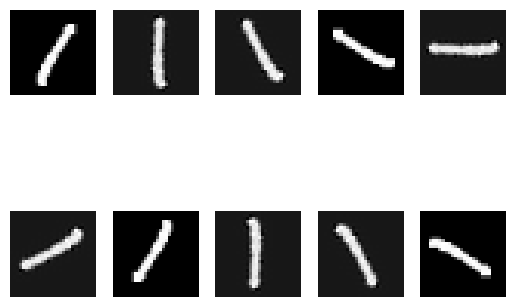

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 

d = np.load('mnist_rotated_1_2.npz')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(d['x'][i].reshape(28, 28), cmap='gray')
    plt.axis('off')